In [6]:
import sys
sys.path.append('../code')
from tensornetwork.stopping import Cutoff,no_truncation
from tensornetwork.linalg import truncated_svd
from tensornetwork.MPS import MPS 
from quantum.hamiltonians import heisenberg
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import time 
import numpy as np 
import scipy
from tqdm import tqdm 
def random_tensor(*args, a=-.5, b=1, dtype=np.complex128):
        output = a + (b - a) * np.random.rand(*args).astype(dtype)
        output /= np.linalg.norm(output)
        return output


In [7]:

def dmrg2(mpo,mps, sweeps=10, stop=Cutoff(1e-14), maxit=10,eig_tol=1e-8,eigensolver="Lan"):
    
    """
    Einsum Indexing convention L->R:
     ______                 ______
    |      |    _______    |      |   
    |      |-Z-|mps_c_j|-W-|      |
    |      |   |_______|   |      |
    |      |    __|d___    |      |
    | L[j] |-D-| mpo_j |-E-|R[N-j]|
    |      |   |_______|   |      |
    |      |    __|l___    |      |
    |      |-X-| mps_j |-Y-|      |
    |______|   |_______|   |______|
    """
        
    def compute_right_envs(mps, mpo):
        N = len(mps)  # Assuming mps is a list or array-like object
        R = [None] * N
        
        # -------- Right environments --------
        R[-1] = np.einsum("Ddl,xd->xDl", mpo[-1], np.conj(mps[-1]))
        R[-1] = np.einsum("xDl,Xl->xDX", R[-1], mps[-1])
        
        for i in range(N-2,1,-1):
            R[i] = np.einsum("ydx,xDX->ydDX", np.conj(mps[i]), R[i+1])            
            R[i] = np.einsum("EdDl,ydDX->yElX", mpo[i], R[i])
            R[i] = np.einsum("YlX,yElX->yEY", mps[i], R[i])
        
        return R
        
    mps.canonize_left()
    LR = compute_right_envs(mps, mpo)
    Es = []
    
    # H_eff = None
    approx_solution = mps.copy()
    approx_solution.show()
    
    def eigensolve(H_eff,psi,*args):
        if eigensolver == "srr":
            psi =psi.reshape(-1)
            num_krylov = H_eff.shape[0]
            tol = 1e-2 #literally all of them
            partial = H_eff.shape[0]
            stabilize = 150
            V_srr, D_srr, X_srr = sRR(H_eff, num_krylov, tol, partial,b=psi, stabilize=stabilize)
            
            return D_srr[-1],V_srr[-1]
        elif eigensolver == "Lan":
            energy, psivec = scipy.sparse.linalg.eigsh(H_eff,k=1, which='SA', maxiter=maxit, v0=psi.reshape(-1),tol=eig_tol)
            return energy, psivec

        elif eigensolver == "Dense":
            evals, evecs = eigh(H_eff)
            energy = evals[0]
            psivec = evecs[:,0]
            return energy, psivec
    
    def sweep_scheduler(n, sweeps):
        sequence = np.concatenate([np.arange(n-1), np.arange(n-3, 0, -1)])
        repeated_sequence = np.tile(sequence, sweeps)
        repeated_sequence = np.append(repeated_sequence, 0)
        return list(repeated_sequence)
    
    for k in tqdm(sweep_scheduler(mps.N,sweeps)): #Using 1 indexing
        #================ First Site ================ 
        if k == 0:  
            H_eff = np.einsum("DkEj,yEY->ykDjY",mpo[1],LR[2])
            H_eff = np.einsum("dDl,ykDjY->dkyljY",mpo[0],H_eff)
            H_eff = H_eff.reshape(H_eff.shape[0]*H_eff.shape[1]*H_eff.shape[2], -1)# (ykd,ljy)
            
            psi =  np.einsum("lr,rjY->ljY",approx_solution[0],approx_solution[1]) # (l,j,Y)
            
            energy, psivec = eigensolve(H_eff,psi,eigensolver) 
            Es.append(energy)      

            U, S, Vt = truncated_svd(psivec.reshape(psi.shape[0],psi.shape[1]*psi.shape[2]), stop=stop)
            S = np.diag(S)/np.linalg.norm(np.diag(S))
            approx_solution[0] = U # l x r
            approx_solution[1] = (S @ Vt).reshape(Vt.shape[0],psi.shape[1],psi.shape[2]) #(r,j,Y)
            # approx_solution.show()

            LR[0] = np.einsum("dx,dDl->xDl", np.conj(U), mpo[0])
            LR[0] = np.einsum("xDl,lX->xDX", LR[0], U)
            
            left_sweep = True

        #================ Middle Sites ================ 
        elif 0 < k and k < mps.N-2:
            H_eff = np.einsum("xDX,DdEl->xdElX",LR[k-1],mpo[k])
            H_eff = np.einsum("xdElX,EkFj->xdkFjlX",H_eff,mpo[k+1])  
            H_eff  = np.einsum("xdkFjlX,yFY->xdkyXljY",H_eff,LR[k+2])
            H_eff = H_eff.reshape(H_eff.shape[0]*H_eff.shape[1]*H_eff.shape[2]*H_eff.shape[3],-1)
            
            psi =  np.einsum("Xlr,rjY->XljY",approx_solution[k],approx_solution[k+1])
            energy, psivec = eigensolve(H_eff,psi,eigensolver) 
            Es.append(energy)        

            U, S, Vt = truncated_svd(psivec.reshape(psi.shape[0] * psi.shape[1], psi.shape[2] * psi.shape[3]), stop=stop)
            S = np.diag(S)/np.linalg.norm(np.diag(S))
            
            if left_sweep:
                approx_solution[k] = U.reshape(psi.shape[0], mpo[k].shape[1], U.shape[1])
                approx_solution[k+1] = (S @ Vt).reshape(Vt.shape[0],psi.shape[2],psi.shape[3])
                
                LR[k] = np.einsum("xDX,xdz->zdDX", LR[k - 1], np.conj(approx_solution[k]))
                LR[k] = np.einsum("zdDX,DdEl->zElX", LR[k], mpo[k])
                LR[k] = np.einsum("zElX,XlZ->zEZ", LR[k], approx_solution[k])
            else:
                approx_solution[k] = (U @ S).reshape(psi.shape[0], mpo[k].shape[1], U.shape[1])
                approx_solution[k+1] = Vt.reshape(Vt.shape[0],psi.shape[2],psi.shape[3])
                
                LR[k+1] = np.einsum("yEY,zdy->zdEY", LR[k+2], np.conj(approx_solution[k+1]))
                LR[k+1] = np.einsum("zdEY,DdEl->zDlY", LR[k+1], mpo[k+1])
                LR[k+1] = np.einsum("zDlY,ZlY->zDZ", LR[k+1], approx_solution[k+1])
            # approx_solution.show()


        #================ Last Site ================  Index =  N -1  and N  
        else: # k == mps.N-2
            H_eff = np.einsum("xDX,DdEl->xdElX",LR[-3],mpo[-2])
            H_eff = np.einsum("xdElX,Ekj->xdkXlj",H_eff,mpo[-1])
            H_eff= H_eff.reshape(H_eff.shape[0]*H_eff.shape[1]*H_eff.shape[2],-1)
            
            psi = np.einsum("Xlr,rj->Xlj",approx_solution[-2],approx_solution[-1])
            energy, psivec = eigensolve(H_eff,psi,eigensolver)  
            Es.append(energy)        

            U, S, Vt = truncated_svd(psivec.reshape(psi.shape[0] * psi.shape[1], psi.shape[2]), stop=stop)
            S = np.diag(S)/np.linalg.norm(np.diag(S))
            approx_solution[-2] = (U @ S).reshape(psi.shape[0], approx_solution[-2].shape[1], psi.shape[2])
            approx_solution[-1] = Vt.reshape(psi.shape[2], approx_solution[-1].shape[1])
            # approx_solution.show()

            LR[-1] = np.einsum("Ddl,yd->yDl", mpo[-1], np.conj(approx_solution[-1]))
            LR[-1] = np.einsum("yDl,Yl->yDY", LR[-1], approx_solution[-1])
            
            left_sweep = False

    approx_solution[0] = U @ S
    approx_solution[1] = Vt.reshape(Vt.shape[0],psi.shape[1],psi.shape[2])
    mps = MPS(approx_solution)
    mps.canform="Left"
            
    return mps, Es


In [8]:
N = 8
J = -1  
chi =1
d=2
 
np.random.seed(42)

mpo = heisenberg(N,"heis")

def flatten_mpo(mpo):
    tmp = np.einsum("arb,rARB->aAbBR",mpo[0],mpo[1])
    tmp = tmp.reshape((4,4,mpo[1].shape[2]))
    size = 4
    for i in range(2,mpo.N-1):
        tmp = np.einsum("abr,rARB->aAbBR",tmp,mpo[i])
        size *= 2
        tmp = tmp.reshape((size,size,mpo[i].shape[2]))
    H = np.einsum("abr,rAB->aAbB",tmp,mpo[-1])
    size *= 2
    H = H.reshape(size,size)
    return H 
H = flatten_mpo(mpo)

eigenvalues, eigenvectors = np.linalg.eigh(H)
ground_state_energy = min(eigenvalues)

guess = MPS.random_mps(N, chi, random_tensor=random_tensor,dtype=np.complex128)

print("MPO approximation error",np.linalg.norm(flatten_mpo(mpo)-H)/np.linalg.norm(H))
mpo.show()
# print(eigenvalues)


MPO approximation error 0.0
│5│5│5│5│5│5│5│
●─●─●─●─●─●─●─●
│ │ │ │ │ │ │ │


│1│1│1│1│1│1│1│
>-■-■-■-■-■-■-<


100%|██████████| 61/61 [00:00<00:00, 684.78it/s]


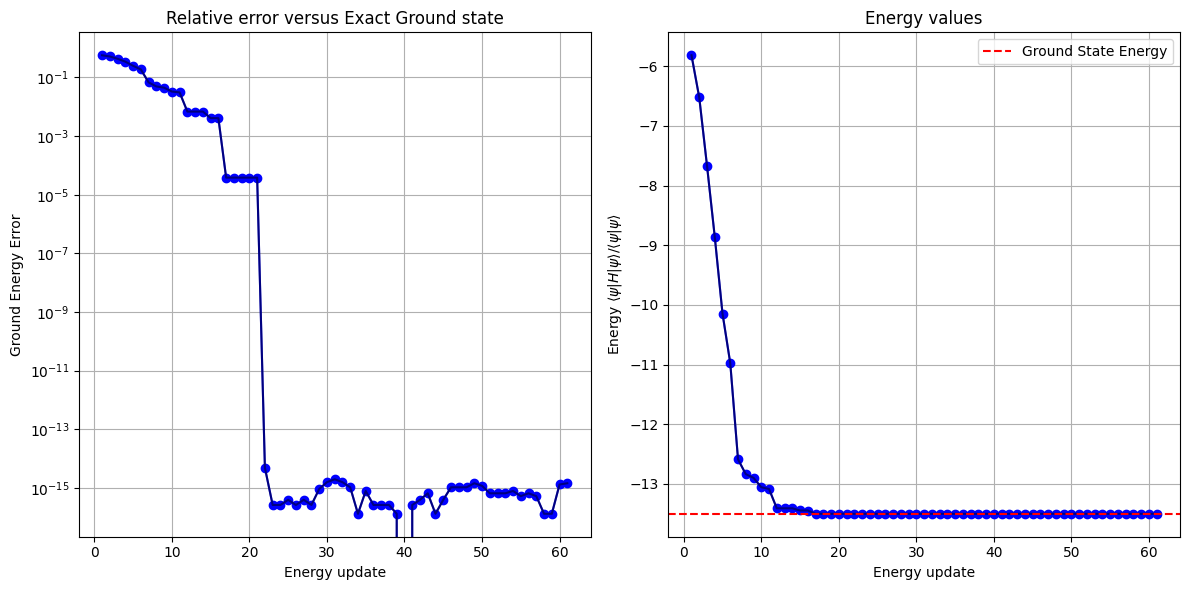

Ground state energy: (exact) -13.499730394751557
Ground state energy: (DMRG) [-13.49973039]


In [9]:

np.random.seed(42)
sweeps=5
stop = no_truncation()
mpo = heisenberg(N,"heis")
guess = MPS.random_mps(N, chi, random_tensor=random_tensor,dtype=np.complex128)

eig, Es = dmrg2(mpo, guess, sweeps=sweeps, stop=stop, maxit=1000, eig_tol=1e-16,eigensolver="Lan")


x_values = np.arange(1, len(Es) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

uniform_color = 'blue'
ax1.set_yscale('log')
ax1.plot(x_values, np.abs(Es - ground_state_energy) / np.abs(ground_state_energy), 'o-', color=uniform_color)
ax1.plot(x_values, np.abs(Es - ground_state_energy) / np.abs(ground_state_energy), 'k-', alpha=0.5)
ax1.set_title('Relative error versus Exact Ground state')
ax1.set_xlabel('Energy update')
ax1.set_ylabel('Ground Energy Error')
ax1.grid(True)

ax2.plot(x_values, Es, 'o-', color=uniform_color)
ax2.plot(x_values, Es, 'k-', alpha=0.5)
ax2.axhline(y=ground_state_energy, color='r', linestyle='--', label='Ground State Energy')
ax2.set_xlabel('Energy update')
ax2.set_ylabel(r'Energy $\langle\psi| H |\psi\rangle / \langle\psi | \psi\rangle$')
ax2.set_title('Energy values')
ax2.grid(True)

ax2.legend()

plt.tight_layout()
plt.show()

print("Ground state energy: (exact)", ground_state_energy)
print("Ground state energy: (DMRG)", Es[-1])